# Post-process harmonization of MODIS and AVHRR

Firstly, generate plots comparing before and after the calibration

Then, combine the calibrated AVHRR 1982-2000 timseries with MODIS 2001-2022 and export

<!-- Following [Rifai et al. (2022)](https://bg.copernicus.org/articles/19/491/2022/)

    <var>-MODIS = s(<var>-AVHRR)+s(month)+s(SZA)+s(TOD)+s(x,y)

This process was run using an R script and the `mgcv` package. This notebook post-processes the output of the GAM harmonization:
- Create plots of before and after harmonization
- Merging the calibrated AVHRR with MODIS to create a continous time-series 1982-2022
- Gapfilling -->
    
        
    


In [1]:
import numpy as np
import xarray as xr
import seaborn as sb
import pandas as pd
import geopandas as gpd
from scipy import stats
import xskillscore as xs
import contextily as ctx
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from scipy.stats import gaussian_kde
from sklearn.metrics import mean_absolute_error
from matplotlib.ticker import FormatStrFormatter

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from _collect_prediction_data import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

# Using ggplot styles in this notebook
plt.style.use('ggplot')

%matplotlib inline

## Analysis Parameters

In [3]:
model_var='NDVI'
crs='epsg:4326'

name = 'AUS'

base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'

## Open datasets

In [3]:
trees = xr.open_dataset(base+'NDVI_harmonization/NDVI_trees_GAM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
nontrees = xr.open_dataset(base+'NDVI_harmonization/NDVI_nontrees_GAM_harmonize_5km_monthly_1982_2013.nc')['NDVI']

avhrr = xr.open_dataset(base+model_var+'_harmonization/AVHRR_'+model_var+'_5km_monthly_1982_2013.nc')[model_var+'_avhrr']
avhrr = assign_crs(avhrr, crs=crs)
avhrr = round_coords(avhrr)

modis = xr.open_dataset(base+model_var+'_harmonization/MODIS_'+model_var+'_5km_monthly_200003_202212.nc')[model_var+'_median']
modis = assign_crs(modis, crs=crs)
modis = round_coords(modis)

### Combine trees and nontrees model predictions (unless LST)

In [4]:
if model_var == 'NDVI':
    merge = xr.where(np.isnan(trees), nontrees, trees)
    # merge = merge.rename({'y':'latitude', 'x': 'longitude'})

if model_var=='LST':
    merge = xr.open_dataset(base+model_var+'_harmonization/'+model_var+'_AUS_LGBM_harmonize_5km_monthly_1982_2013.nc')[model_var]
    merge = assign_crs(merge, crs=crs)
    merge = merge.rename({'y':'latitude', 'x': 'longitude'})
    merge = round_coords(merge)
    
#gam
# merge = xr.open_dataset(base+model_var+'_harmonization/'+'Harmonized_GAM_CLIM_NDVI_AVHRR_MODIS_1982_2013.nc')['ndvi_mcd_pred'].rename(model_var)
# merge = assign_crs(merge, crs=crs)

#ensure we only have data where there is AVHRR data (this is unnecessary but being sure)
avhrr_mask = xr.open_dataarray('/g/data/os22/chad_tmp/climate-carbon-interactions/data/'+model_var+'_harmonization/AVHRR_'+model_var+'_filtered_mask_1982_2013.nc')
avhrr_mask = round_coords(avhrr_mask)
merge = merge.where(avhrr_mask)

#clip MODIS to same areas/time
modis = modis.sel(time=slice('2000', '2013')).where(avhrr_mask.sel(time=slice('2000-03', '2013')))

#modis has very slightly different extent so clip further
modis_mask = ~np.isnan(modis)
merge = merge.sel(time=modis.time).where(modis_mask)
avhrr = avhrr.sel(time=modis.time)
avhrr = avhrr.where(modis_mask)

## Comparisons

### Scatter plots of before and after harmonization

#### trees/non-trees

In [5]:
# trees_mask = (~np.isnan(trees.mean('time'))).rename({'y':'latitude', 'x': 'longitude'})
# nontrees_mask = (~np.isnan(nontrees.mean('time'))).rename({'y':'latitude', 'x': 'longitude'})

trees_mask = (~np.isnan(trees.mean('time')))
nontrees_mask = (~np.isnan(nontrees.mean('time')))

In [6]:
modis_trees_flat = modis.where(trees_mask).values.flatten()
avhrr_trees_flat = avhrr.where(trees_mask).values.flatten()
# avhrr_trees_adjust_flat = trees_lgbm.sel(time=modis.time).values.flatten()
avhrr_trees_adjust_flat = merge.where(trees_mask).sel(time=modis.time).values.flatten()

df_trees = pd.DataFrame({'MODIS':modis_trees_flat, 'AVHRR-original':avhrr_trees_flat, 'AVHRR-adjusted':avhrr_trees_adjust_flat})
df_trees = df_trees.dropna().sample(n=10000, random_state=0).reset_index(drop=True)

modis_nontrees_flat = modis.where(nontrees_mask).values.flatten()
avhrr_nontrees_flat = avhrr.where(nontrees_mask).values.flatten()
# avhrr_nontrees_adjust_flat = nontrees_lgbm.sel(time=modis.time).values.flatten()
avhrr_nontrees_adjust_flat = merge.where(nontrees_mask).sel(time=modis.time).values.flatten()

df_nontrees = pd.DataFrame({'MODIS':modis_nontrees_flat, 'AVHRR-original':avhrr_nontrees_flat, 'AVHRR-adjusted':avhrr_nontrees_adjust_flat})
df_nontrees = df_nontrees.dropna().sample(n=10000, random_state=0).reset_index(drop=True)

Text(0.02, 0.5, 'AVHRR NDVI')

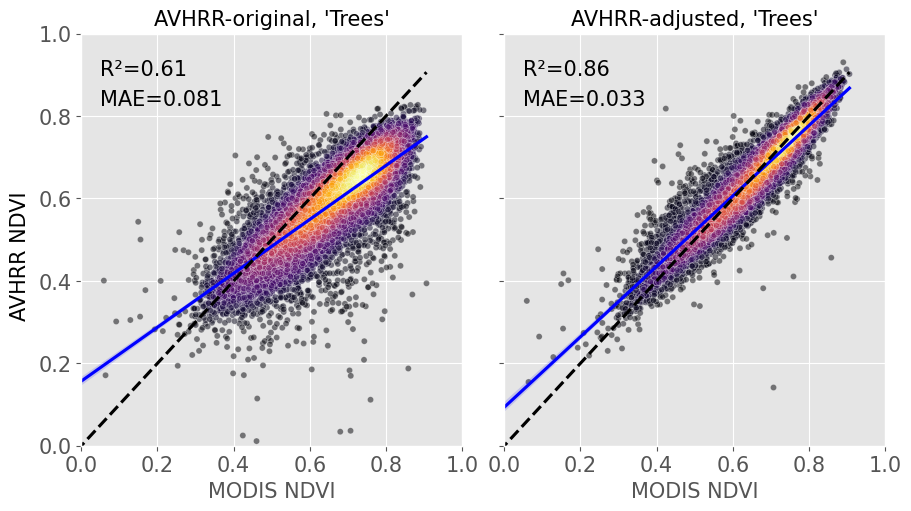

In [7]:
products=['AVHRR-original', 'AVHRR-adjusted']


fig,ax = plt.subplots(1,2, figsize=(9,5), sharey=True, layout='constrained')
font=15

for prod, ax in zip(products, ax.ravel()):
    obs,pred = df_trees['MODIS'].values, df_trees[prod].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    r2 = r_value**2
    ac = mean_absolute_error(obs, pred)
    
    xy = np.vstack([obs,pred])
    z = gaussian_kde(xy)(xy)
    
    sb.scatterplot(data=df_trees, x='MODIS',y=prod, c=z, s=20, lw=1, alpha=0.5, ax=ax, cmap='inferno')
    sb.regplot(data=df_trees, x='MODIS',y=prod, scatter=False, color='blue', ax=ax)
    sb.regplot(data=df_trees, x='MODIS',y='MODIS', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax)
    ax.set_title(prod + ", 'Trees'", fontsize=font)
    ax.set_xlabel('MODIS '+model_var, fontsize=font)
    ax.set_ylabel('')
    if model_var=='NDVI':
        ax.set_ylim(0.0,1.0)
        ax.set_xlim(0.0,1.0)
    if model_var=='LST':
        ax.set_ylim(260,330)
        ax.set_xlim(260,330)
    ax.text(.05, .90, 'R\N{SUPERSCRIPT TWO}={:.2f}'.format(np.mean(r2)),
            transform=ax.transAxes, fontsize=font)
    ax.text(.05, .825, 'MAE={:.2g}'.format(np.mean(ac)),
            transform=ax.transAxes, fontsize=font)
    ax.tick_params(axis='x', labelsize=font)
    ax.tick_params(axis='y', labelsize=font)

fig.supylabel('AVHRR '+model_var, fontsize=font)
# fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/MODIS_AVHRR_"+model_var+"_onetoone_Trees_harmonization.png", bbox_inches='tight', dpi=300);

Text(0.02, 0.5, 'AVHRR NDVI')

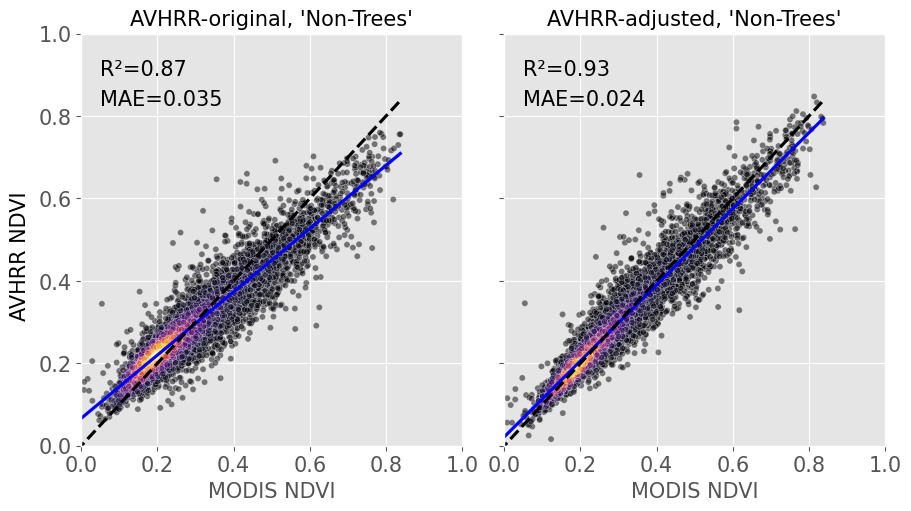

In [8]:
products=['AVHRR-original', 'AVHRR-adjusted']

fig,ax = plt.subplots(1,2, figsize=(9,5), sharey=True, layout='constrained')
font=15

for prod, ax in zip(products, ax.ravel()):
    obs,pred = df_nontrees['MODIS'].values, df_nontrees[prod].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    r2 = r_value**2
    ac = mean_absolute_error(obs, pred)
    
    xy = np.vstack([obs,pred])
    z = gaussian_kde(xy)(xy)
    
    sb.scatterplot(data=df_nontrees, x='MODIS',y=prod, c=z, s=20, lw=1, alpha=0.5, ax=ax, cmap='inferno')
    sb.regplot(data=df_nontrees, x='MODIS',y=prod, scatter=False, color='blue', ax=ax)
    sb.regplot(data=df_nontrees, x='MODIS',y='MODIS', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax)
    ax.set_title(prod + ", 'Non-Trees'", fontsize=font)
    ax.set_xlabel('MODIS '+model_var, fontsize=font)
    ax.set_ylabel('')
    if model_var=='NDVI':
        ax.set_ylim(0.0,1.0)
        ax.set_xlim(0.0,1.0)
    if model_var=='LST':
        ax.set_ylim(270,340)
        ax.set_xlim(270,340)
    ax.text(.05, .90, 'R\N{SUPERSCRIPT TWO}={:.2f}'.format(np.mean(r2)),
            transform=ax.transAxes, fontsize=font)
    ax.text(.05, .825, 'MAE={:.2g}'.format(np.mean(ac)),
            transform=ax.transAxes, fontsize=font)
    ax.tick_params(axis='x', labelsize=font)
    ax.tick_params(axis='y', labelsize=font)

fig.supylabel('AVHRR '+model_var, fontsize=font)
# fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/MODIS_AVHRR_"+model_var+"_onetoone_NonTrees_harmonization.png", bbox_inches='tight', dpi=300);

#### Per bioclimatic region

In [9]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')
n_samples=60000

In [10]:
# Dictionary to save results 
results = []
for index, row in gdf.iterrows():

    n=int(n_samples/6)        

    print(row['region_name'], n)
    
    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], merge, crs=crs)
    mask = round_coords(mask)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    modis_flat = modis.where(mask).values.flatten()
    avhrr_flat = avhrr.where(mask).values.flatten()
    avhrr_adjust = merge.where(mask).values.flatten()

    df = pd.DataFrame({'MODIS':modis_flat, 'AVHRR-original':avhrr_flat, 'AVHRR-adjusted':avhrr_adjust})
    df = df.dropna().sample(n=n, random_state=0).reset_index(drop=True)
    df['Region'] = row['region_name']
    results.append(df)

df = pd.concat(results).reset_index(drop=True)

Tropics 10000
Savanna 10000
Warm Temperate 10000
Cool Temperate 10000
Mediterranean 10000
Desert 10000


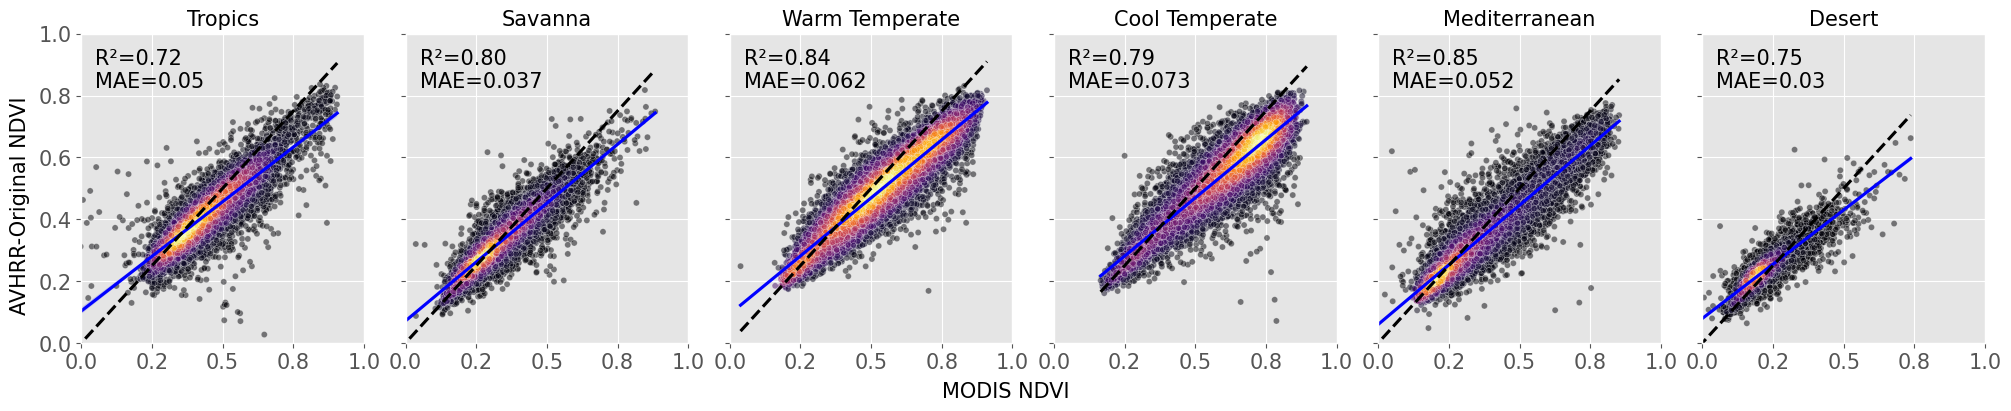

In [11]:
fig,ax = plt.subplots(1,6, figsize=(20,4), sharey=True, layout='constrained')
font=15

for ax, region in zip(ax.ravel(), list(df['Region'].unique())):
    df_region = df[df['Region']==region]
    obs,pred = df_region['MODIS'].values, df_region['AVHRR-original'].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    r2 = r_value**2
    ac = mean_absolute_error(obs, pred)
    
    xy = np.vstack([obs,pred])
    z = gaussian_kde(xy)(xy)
    
    sb.scatterplot(data=df_region, x='MODIS',y='AVHRR-original', c=z, s=20, lw=1, alpha=0.5, ax=ax, cmap='inferno')
    sb.regplot(data=df_region, x='MODIS',y='AVHRR-original', scatter=False, color='blue', ax=ax)
    sb.regplot(data=df_region, x='MODIS',y='MODIS', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax)
    
    ax.set_title(region, fontsize=font)
    ax.set_xlabel('')
    ax.set_ylabel('')
    if model_var=='NDVI':
        ax.set_ylim(0.0,1.0)
        ax.set_xlim(0.0,1.0)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if model_var=='LST':
        ax.set_ylim(265,340)
        ax.set_xlim(265,340)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.text(.05, .90, 'R\N{SUPERSCRIPT TWO}={:.2f}'.format(np.mean(r2)),
            transform=ax.transAxes, fontsize=font)
    ax.text(.05, .825, 'MAE={:.2g}'.format(np.mean(ac)),
            transform=ax.transAxes, fontsize=font)
    
    ax.tick_params(axis='x', labelsize=font)
    ax.tick_params(axis='y', labelsize=font)

fig.supylabel('AVHRR-Original '+model_var, fontsize=font)
fig.supxlabel('MODIS '+model_var, fontsize=font);
# fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/MODIS_AVHRR_"+model_var+"_onetoone_before_harmonization.png", bbox_inches='tight', dpi=300);

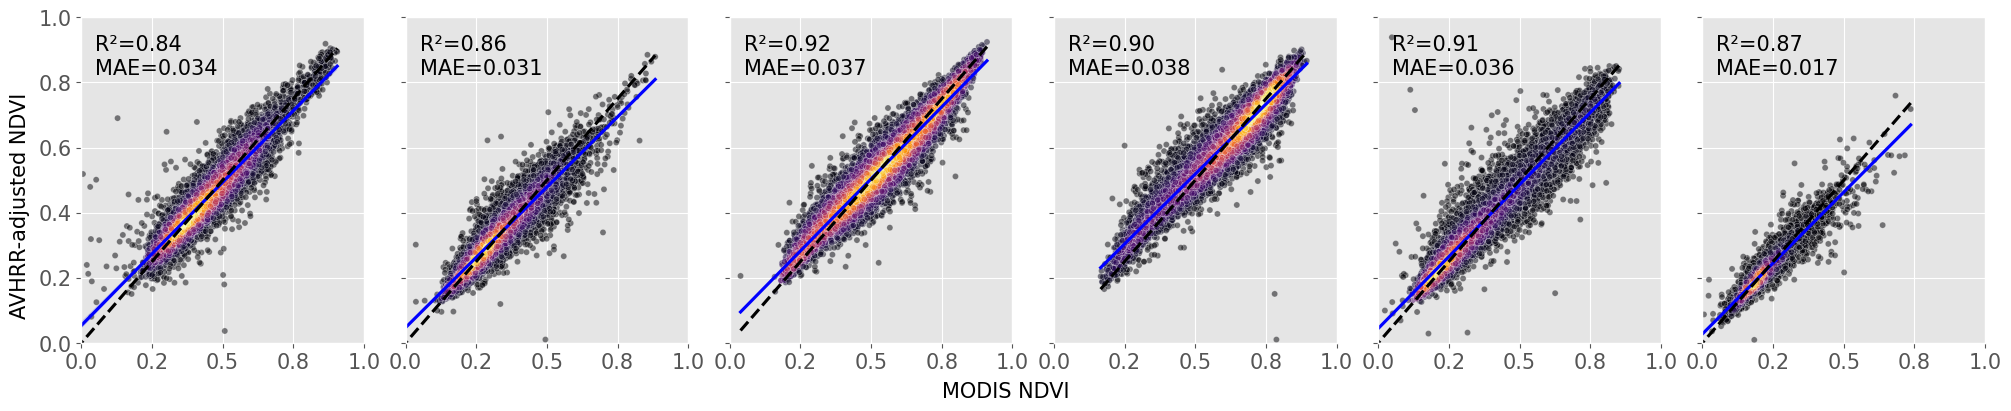

In [12]:
fig,ax = plt.subplots(1,6, figsize=(20,4), sharey=True, layout='constrained')
font=15

for ax, region in zip(ax.ravel(), list(df['Region'].unique())):
    df_region = df[df['Region']==region]
    obs,pred = df_region['MODIS'].values, df_region['AVHRR-adjusted'].values
    slope, intercept, r_value, p_value, std_err = stats.linregress(obs,pred)
    r2 = r_value**2
    ac = mean_absolute_error(obs, pred)
    
    xy = np.vstack([obs,pred])
    z = gaussian_kde(xy)(xy)
    
    sb.scatterplot(data=df_region, x='MODIS',y='AVHRR-adjusted', c=z, s=20, lw=1, alpha=0.5, ax=ax, cmap='inferno')
    sb.regplot(data=df_region, x='MODIS',y='AVHRR-adjusted', scatter=False, color='blue', ax=ax)
    sb.regplot(data=df_region, x='MODIS',y='MODIS', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax)
    
    ax.set_title('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    if model_var=='NDVI':
        ax.set_ylim(0.0,1.0)
        ax.set_xlim(0.0,1.0)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if model_var=='LST':
        ax.set_ylim(265,340)
        ax.set_xlim(265,340)
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax.text(.05, .90, 'R\N{SUPERSCRIPT TWO}={:.2f}'.format(np.mean(r2)),
            transform=ax.transAxes, fontsize=font)
    ax.text(.05, .825, 'MAE={:.2g}'.format(np.mean(ac)),
            transform=ax.transAxes, fontsize=font)
    ax.tick_params(axis='x', labelsize=font)
    ax.tick_params(axis='y', labelsize=font)

fig.supylabel('AVHRR-adjusted '+model_var, fontsize=font)
fig.supxlabel('MODIS '+model_var, fontsize=font);
# fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/MODIS_AVHRR_"+model_var+"_onetoone_after_harmonization.png", bbox_inches='tight', dpi=300);

### Timeseries plots


#### per region

Tropics
Savanna
Warm Temperate
Cool Temperate
Mediterranean
Desert


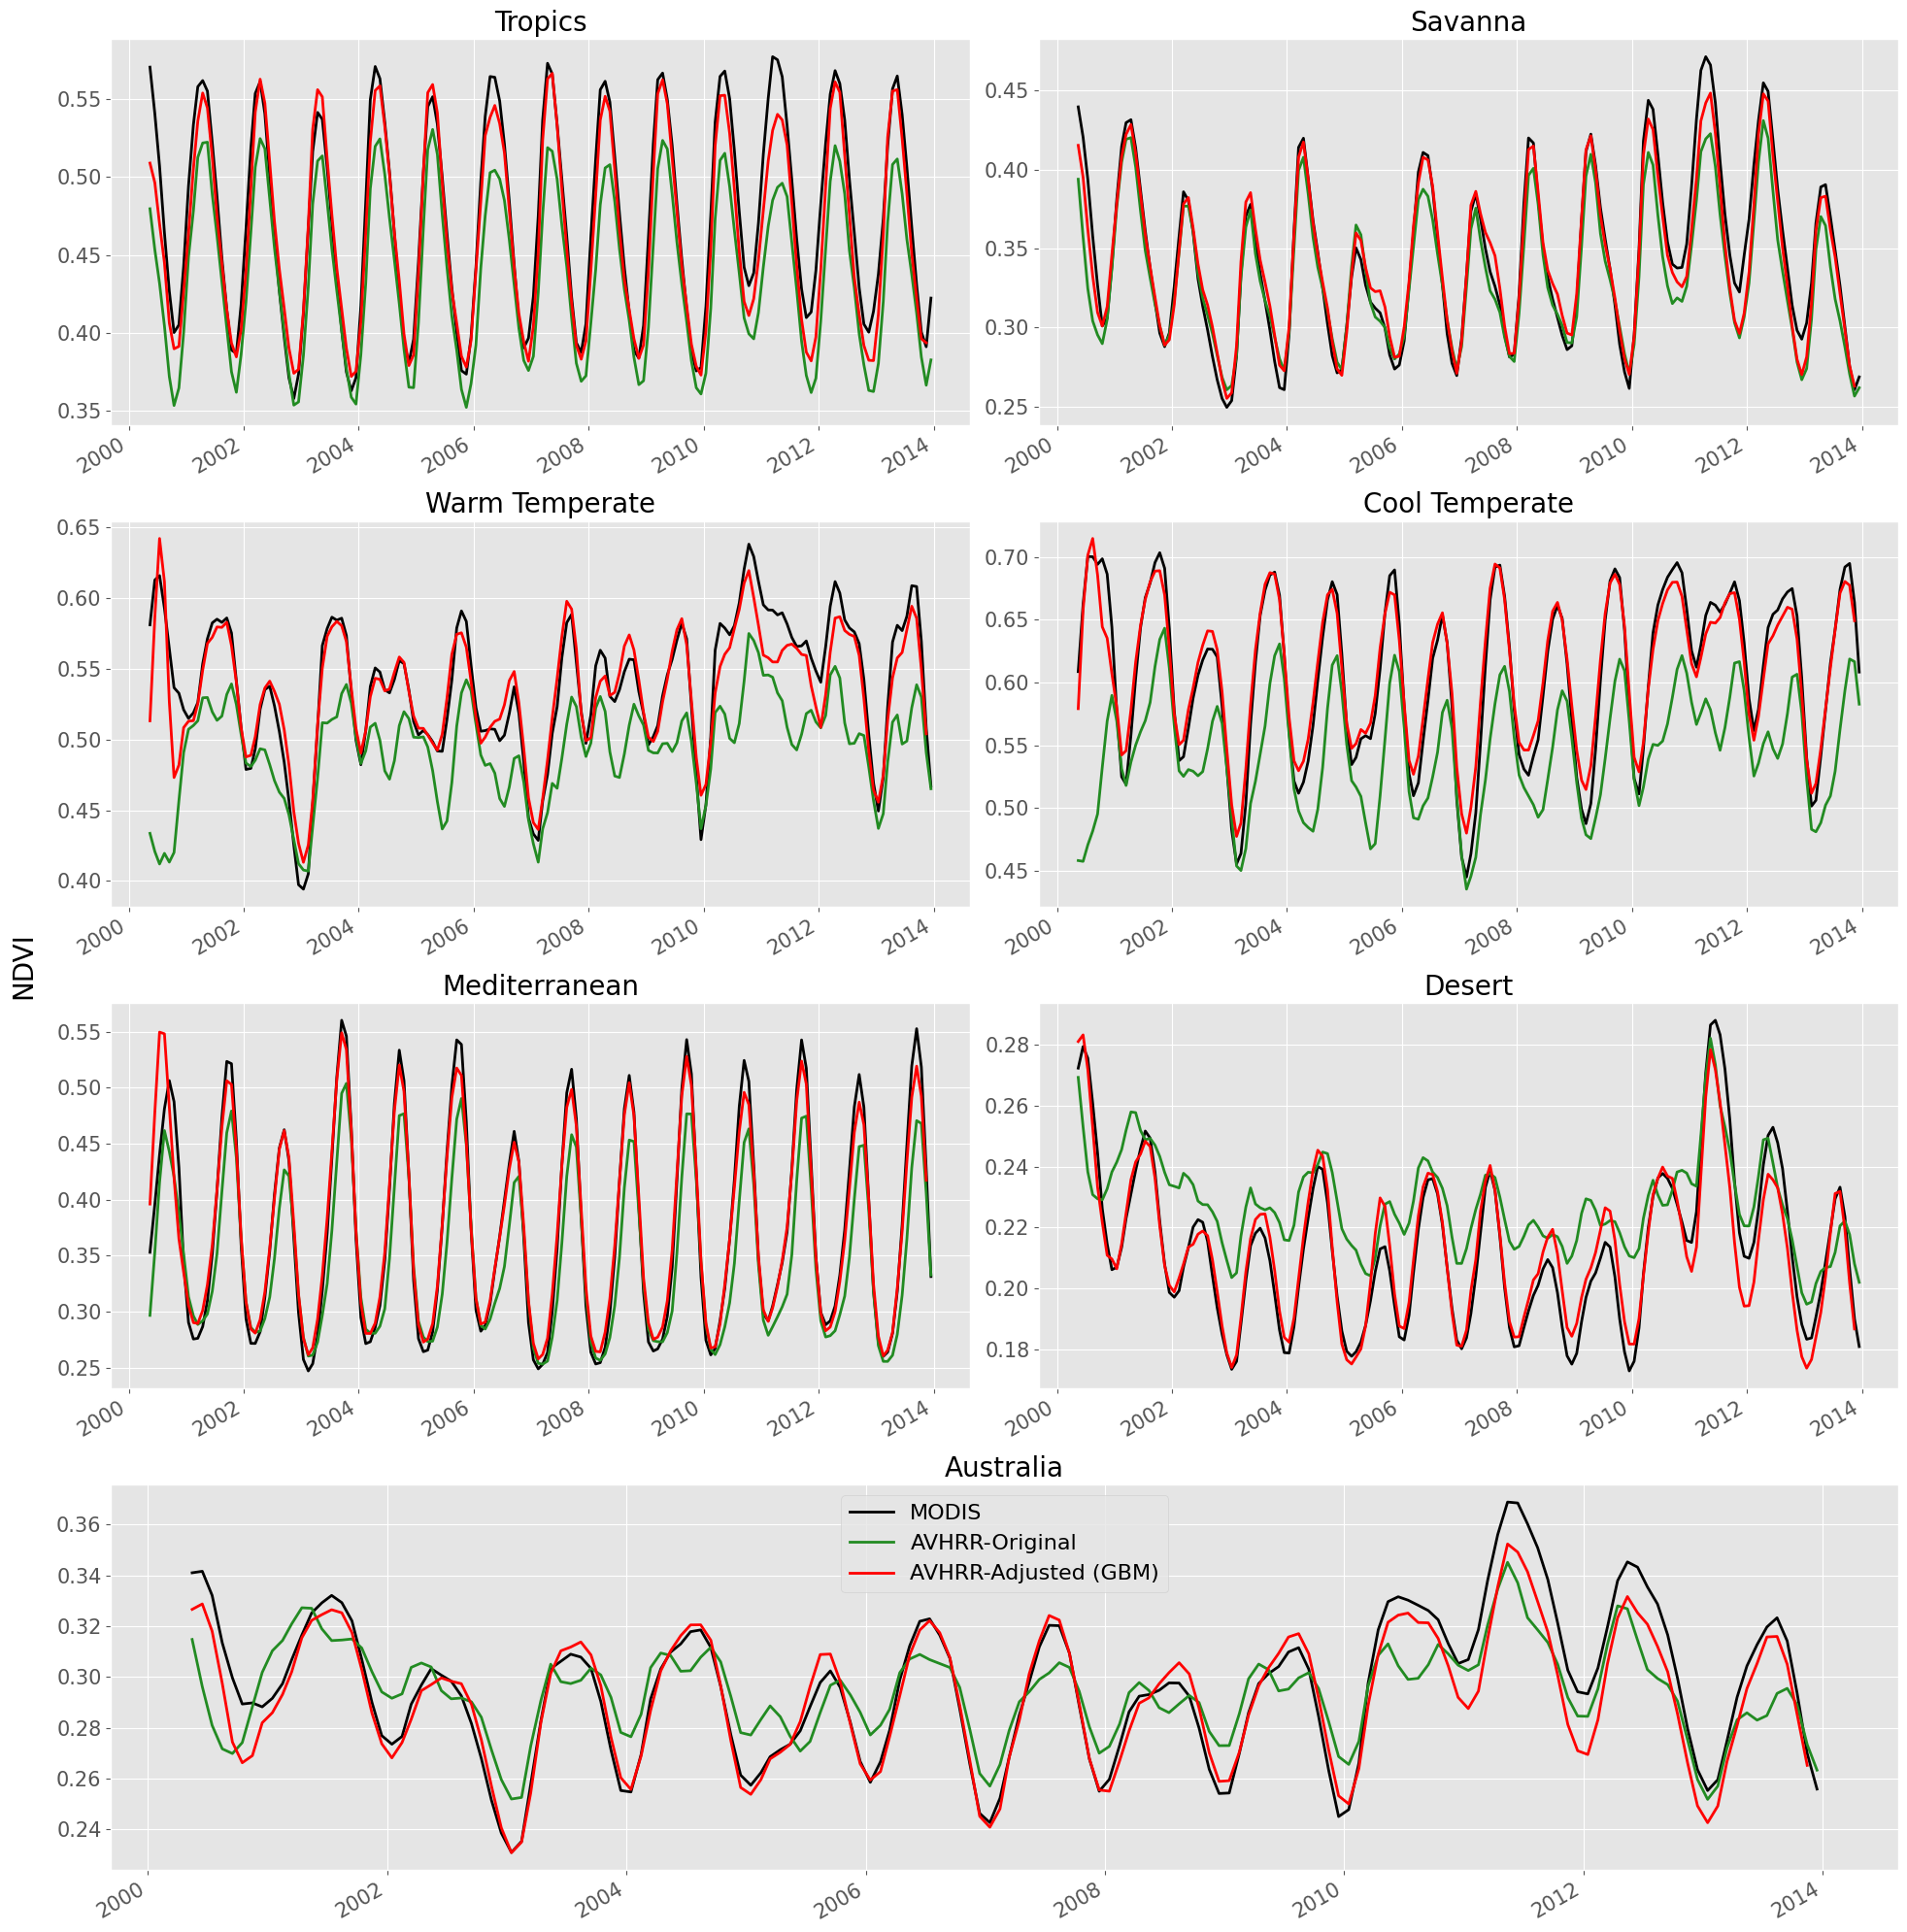

In [13]:
mosiac = [
    ["A", "B"],
    ["C", "D"],
    ["E", "F"],
    ["G", "G"],
]

fig, axes = plt.subplot_mosaic(mosiac, figsize=(20,20))

for ax, (index, row) in zip(axes, gdf.iterrows()):
    print(row['region_name'])
    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], merge, crs=crs)
    mask = round_coords(mask)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    modis_region = modis.where(mask)
    avhrr_region = avhrr.where(mask)
    merge_region = merge.where(mask)

    modis_region.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes[ax], label='MODIS', c='black', linewidth=2)
    avhrr_region.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes[ax], label='AVHRR original', c ='forestgreen', linewidth=2)
    merge_region.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes[ax], label='AVHRR adjusted', c='red', linewidth=2)
    axes[ax].set_ylabel('')
    axes[ax].set_xlabel('')
    # axes[ax].sharex(axes['E'])
    axes[ax].tick_params(axis='y', labelsize=15)
    axes[ax].tick_params(axis='x', labelsize=15)
    axes[ax].set_title(row['region_name'], fontsize=20)
    axes[ax].grid(True)

#the last Aus-wide plot
modis.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes['G'], label='MODIS', color='black', linewidth=2)
avhrr.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes['G'], label='AVHRR-Original', c ='forestgreen', linewidth=2)
merge.mean(['latitude','longitude']).rolling(time=3).mean().plot(ax=axes['G'], label='AVHRR-Adjusted (GBM)', c='red', linewidth=2)
axes['G'].set_title('Australia', fontsize=20)
axes['G'].legend(fontsize=16)
axes['G'].set_ylabel('')
axes['G'].set_xlabel('')
axes['G'].tick_params(axis='y', labelsize=15)
axes['G'].tick_params(axis='x', labelsize=15)
axes['G'].grid(True)

fig.supylabel(model_var, fontsize=20)    
plt.tight_layout(rect=(0.015,0,1,1))
# fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/MODIS_AVHRR_"+model_var+"_timeseries_bioregion.png", bbox_inches='tight', dpi=300);

### Per-pixel error metrics

In [14]:
modis_mean = modis.mean('time')
low_ndvi_mask = xr.where(modis_mean<0.10,0, 1)

In [15]:
adjusted_corr = xr.corr(modis.sel(time=slice('2000-03', '2013')),
                        merge.sel(time=slice('2000-03', '2013')), dim='time')
adjusted_corr = adjusted_corr.where(low_ndvi_mask)

orig_corr = xr.corr(modis.sel(time=slice('2000-03', '2013')),
                    avhrr.sel(time=slice('2000-03', '2013')), dim='time')
orig_corr = orig_corr.where(low_ndvi_mask)

adjusted_rmse = xs.rmse(modis.sel(time=slice('2000-03', '2013')),
                        merge.sel(time=slice('2000-03', '2013')), dim='time', skipna=True)
adjusted_rmse = adjusted_rmse.where(low_ndvi_mask)

orig_rmse = xs.rmse(modis.sel(time=slice('2000-03', '2013')),
                    avhrr.sel(time=slice('2000-03', '2013')), dim='time', skipna=True)
orig_rmse = orig_rmse.where(low_ndvi_mask)

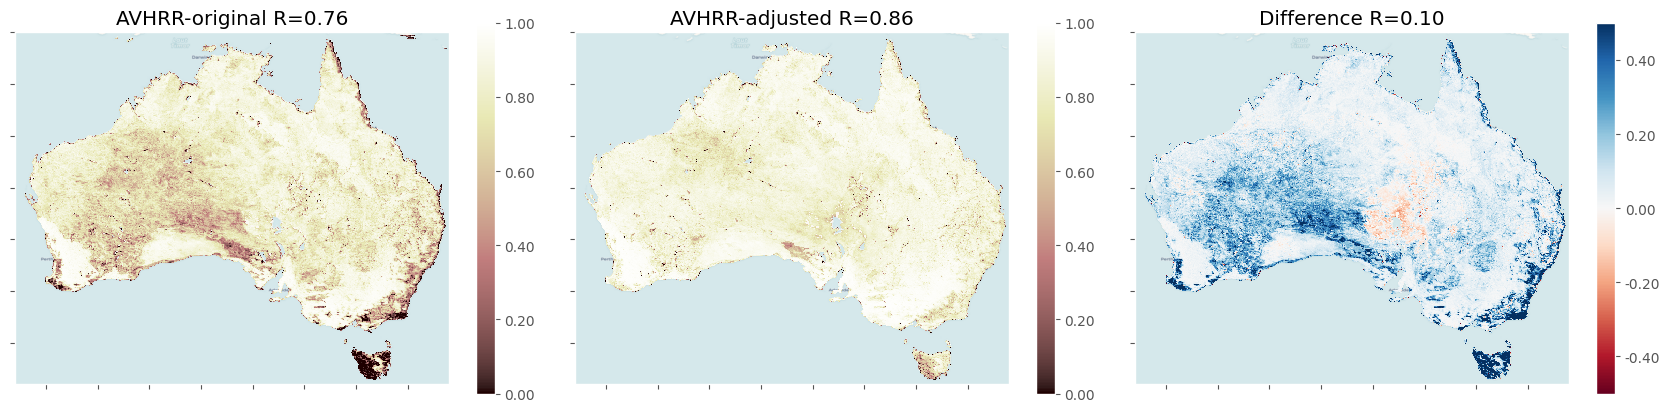

In [16]:
corr_data = [orig_corr, adjusted_corr, adjusted_corr-orig_corr]
products=['AVHRR-original', 'AVHRR-adjusted', 'Difference']

fig,axes = plt.subplots(1,3, figsize=(17,6), sharey=True)

for ax, ds, n in zip(axes.ravel(), corr_data, products):
    if n=='Difference':
        cmap='RdBu'
        vmin=-0.5
        vmax=0.5
    else:
        cmap='pink'
        vmin=0
        vmax=1
    im = ds.plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)
    cbar = plt.colorbar(im, ax=ax, shrink=0.65)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.set_title(f'{n} R='"{:.2f}".format(ds.mean().values))
    ax.set_yticklabels([])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels([])
plt.tight_layout()
# fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/MODIS_AVHRR_"+model_var+"_correlation_perpixel.png", bbox_inches='tight', dpi=300);

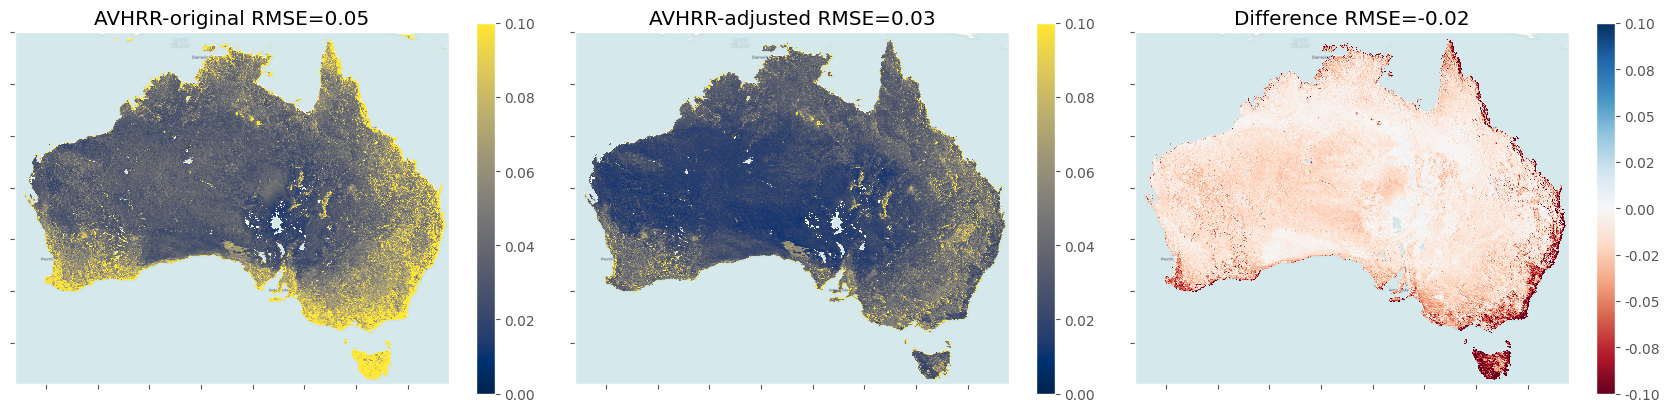

In [17]:
corr_data = [orig_rmse, adjusted_rmse, adjusted_rmse-orig_rmse]
products=['AVHRR-original', 'AVHRR-adjusted', 'Difference']

fig,axes = plt.subplots(1,3, figsize=(17,6), sharey=True)

for ax, ds, n in zip(axes.ravel(), corr_data, products):
    if model_var=='NDVI':
        if n=='Difference':
            cmap='RdBu'
            vmin=-0.1
            vmax=0.1
        else:
            cmap='cividis'
            vmin=0.0
            vmax=0.1
    
    if model_var=='LST':
        if n=='Difference':
            cmap='RdBu'
            vmin=-6
            vmax=6
        else:
            cmap='cividis'
            vmin=0
            vmax=7.0
    im = ds.plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)   
    cbar = plt.colorbar(im, ax=ax, shrink=0.65)
    cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(f'{n} RMSE='"{:.2f}".format(ds.mean().values))
    ax.set_ylabel('')
    ax.set_xlabel('')
plt.tight_layout()
# fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/MODIS_AVHRR_"+model_var+"_RMSE_perpixel.png", bbox_inches='tight', dpi=300);

## Residuals through time



In [18]:
#residuals after harmonization
residual = (modis - merge).mean(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='Residuals')
residual_sd = (modis - merge).std(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='Residuals')

#residuals before harmonization
residual_b = (modis - avhrr).mean(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='Residuals')
residual_sd_b = (modis - avhrr).std(['latitude', 'longitude']).drop('spatial_ref').to_dataframe(name='Residuals')

/g/data/os22/chad_tmp/climate-carbon-interactions/envs/python392/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


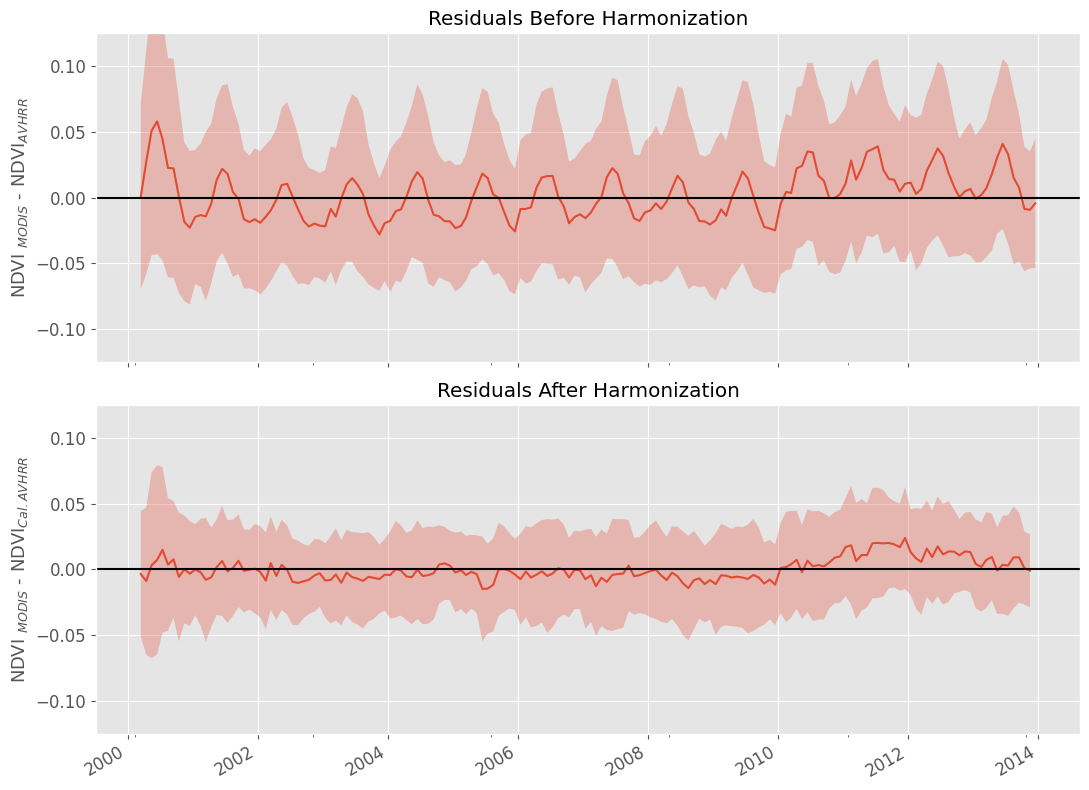

In [19]:
fig,ax = plt.subplots(2,1, figsize=(11,8), sharex=True)
residual_b.plot(ax=ax[0], legend=False)
ax[0].fill_between(residual_b.index, (residual_b-residual_sd_b)['Residuals'],
                   (residual_b+residual_sd_b)['Residuals'], alpha=0.3)
ax[0].axhline(0.0, color='k')
ax[0].set_title('Residuals Before Harmonization')
ax[0].set_ylim(-0.125, 0.125)
ax[0].set_ylabel(model_var+" $_{MODIS}$"+ " - "+model_var+"$_{AVHRR}$", fontsize=13)
ax[0].set_xlabel(None)
ax[0].tick_params(axis='y', labelsize=12)
ax[0].tick_params(axis='x', labelsize=12)

residual.plot(ax=ax[1], legend=False)
ax[1].fill_between(residual.index, (residual-residual_sd)['Residuals'], (residual+residual_sd)['Residuals'], alpha=0.3)
ax[1].axhline(0.0, color='k')
ax[1].set_title('Residuals After Harmonization')
ax[1].set_ylim(-0.125, 0.125)
ax[1].set_ylabel(model_var+" $_{MODIS}$"+ " - "+model_var+"$_{Cal.AVHRR}$", fontsize=13)
ax[1].set_xlabel(None)
ax[1].tick_params(axis='y', labelsize=12)
ax[1].tick_params(axis='x', labelsize=12)

plt.tight_layout()
# fig.savefig("/g/data/os22/chad_tmp/climate-carbon-interactions/results/figs/MODIS_AVHRR_"+model_var+"_residuals.png", bbox_inches='tight', dpi=300);

## Merge calibrated AVHRR with MODIS

reopen datasets and merge

In [4]:
base = '/g/data/os22/chad_tmp/climate-carbon-interactions/data/'

modis = xr.open_dataset(base+model_var+'_harmonization/MODIS_'+model_var+'_5km_monthly_200003_202212.nc')[model_var+'_median']
modis = assign_crs(modis, crs=crs)
modis = round_coords(modis)

if model_var == 'NDVI':
    trees_lgbm = xr.open_dataset(base+'NDVI_harmonization/NDVI_trees_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
    nontrees_lgbm = xr.open_dataset(base+'NDVI_harmonization/NDVI_nontrees_LGBM_harmonize_5km_monthly_1982_2013.nc')['NDVI']
    merge = xr.where(np.isnan(trees_lgbm), nontrees_lgbm, trees_lgbm)
    merge = merge.rename({'y':'latitude', 'x': 'longitude'})

if model_var=='LST':
    merge = xr.open_dataset(base+model_var+'_harmonization/'+model_var+'_AUS_LGBM_harmonize_5km_monthly_1982_2013.nc')[model_var]
    merge = assign_crs(merge, crs=crs)
    merge = merge.rename({'y':'latitude', 'x': 'longitude'})
    merge = round_coords(merge)

# merge = xr.open_dataset(base+model_var+'_harmonization/'+'Harmonized_GAM_CLIM_NDVI_AVHRR_MODIS_1982_2013.nc')['ndvi_mcd_pred'].rename(model_var)
# merge = assign_crs(merge, crs=crs)

In [5]:
merged = xr.concat([merge.sel(time=slice('1982','2000-02')),
                    modis.rename(model_var)],
                   dim='time')
merged = merged.rename(model_var)

(0.2, 0.4)

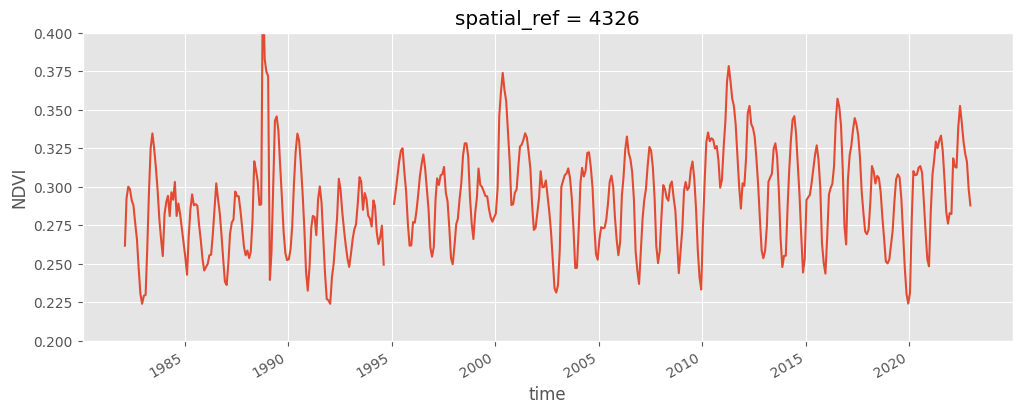

In [7]:
merged.mean(['latitude', 'longitude']).plot(figsize=(12,4))
plt.ylim(0.2,0.4)

### Export netcdf

In [8]:
merged.astype(np.float32).to_netcdf('/g/data/os22/chad_tmp/climate-carbon-interactions/data/'+model_var+'_harmonization/'+model_var+'_LGBM_5km_monthly_1982_2022_wGaps.nc')